In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [5]:
filenames = {
    "herwig": "../data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [9]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('../data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('../data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('../data/processed/np_sig_SR_2.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)

np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)
np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

37

In [10]:
np_sig_SR.shape[0]/np_bg_SR.shape[0]

0.6205640442400567

In [22]:
gen_model = tf.keras.models.load_model('../Results/cdijetgan/saverun4/models/epoch1000-generator.h5')

In [23]:
def generate_gan(generator, realdata):


    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)
   

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)

    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)

    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_bg_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [24]:
real_data = sample_data(size=100000)

In [25]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [26]:
generated_data = generate_gan(gen_model,np_combined_SR)
generated_data2 = generate_gan(gen_model,np_combined_SR)
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)


In [27]:
np_bg_SR_labeled  = np.copy(np_bg_SR)
np_bg_SR_labeled  = np.append(np_bg_SR_labeled ,np.zeros([len(np_bg_SR_labeled) ,1]),1)
np_sig_SR_labeled  = np.copy(np_sig_SR)
np_sig_SR_labeled  = np.append(np_sig_SR_labeled ,np.ones([len(np_sig_SR_labeled) ,1]),1)

In [28]:
gen_data_df = pd.DataFrame(generated_data_labeled, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])
np_sig_df = pd.DataFrame(np_sig_SR_labeled, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [29]:
gen_data_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1240.366674,0.380573,209.133614,1071.856886,-1.536889,2.652903,242.083373,0.835362,0.603953,3433.415527,0.0
1,1733.909712,0.567251,133.514546,1793.047707,0.909862,3.119892,621.439472,0.950038,0.378180,3579.931885,0.0
2,1382.459401,0.814356,132.657246,403.665405,-2.056947,3.723075,76.922235,0.594219,0.767021,3343.528564,0.0
3,1220.226854,1.309399,253.786699,962.904241,-0.826233,2.648015,29.393383,0.258914,0.748940,3499.114014,0.0
4,1777.963687,0.535396,509.312761,1794.679253,0.082154,3.199875,109.566839,0.723776,0.446367,3603.340088,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1484.124208,0.292365,708.086713,1311.044494,-1.061775,3.469861,186.629306,0.144988,0.478857,3442.107666,0.0
99996,1325.472651,-1.170568,234.121937,1167.178912,0.676366,3.202126,72.978088,0.634627,0.688800,3617.594238,0.0
99997,1592.256869,0.791757,289.553807,1585.246045,-0.156222,3.144207,37.598600,0.526267,0.476040,3439.064697,0.0
99998,1432.921196,-0.038133,562.863361,1292.820076,-1.541369,3.208955,57.064643,0.542999,0.598808,3543.805908,0.0


In [30]:
np_sig_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1914.942993,0.369530,105.035004,1583.804443,-0.185737,2.898982,461.574005,0.552809,0.121353,3662.211182,1.0
1,1684.598755,-0.523116,159.865997,1647.186768,0.110357,3.141156,514.883972,0.440781,0.299984,3586.710693,1.0
2,1789.997070,0.156652,93.665901,1569.509399,0.144243,3.235663,475.316986,0.136103,0.135523,3421.777344,1.0
3,1672.631348,-1.015185,116.327003,1568.322998,-0.350886,3.165926,561.236023,0.617014,0.294746,3536.982910,1.0
4,1431.694946,-0.700751,513.015991,1099.721313,0.945019,3.245961,108.752998,0.183145,0.456454,3481.573486,1.0
...,...,...,...,...,...,...,...,...,...,...,...
150591,1678.012939,0.827268,473.352997,1653.355347,0.978250,3.045114,111.844002,0.090573,0.308552,3409.779297,1.0
150592,1741.585083,-0.203934,96.165001,1728.791870,0.121508,3.133633,472.475006,0.202213,0.157020,3581.979492,1.0
150593,1289.501831,0.922850,115.719002,1153.867065,-0.919407,3.193555,489.053009,0.271544,0.203001,3622.836914,1.0
150594,1787.707764,0.032824,508.045013,1381.171143,0.933776,3.163839,91.104897,0.166132,0.588186,3546.809082,1.0


In [31]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model


In [32]:
classifier = classifier_model()
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [33]:

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

In [34]:
# split background in SR into testing and training. Testing is to inject signals
training_idx = np.random.randint(np_bg_SR_labeled.shape[0], size=(int)(np_bg_SR_labeled.shape[0]/2))
test_idx = np.random.randint(np_bg_SR_labeled.shape[0], size=(int)(np_bg_SR_labeled.shape[0]/2))
training, test = np_bg_SR_labeled[training_idx,:], np_bg_SR_labeled[test_idx,:]

In [35]:
training.shape

(121338, 11)

In [36]:
# other half of the bg combined with FULL signal
testing_sample = np.concatenate((np_sig_SR_labeled,test),axis=0)

In [37]:
testing_sample.shape

(271934, 11)

In [38]:
x_test = testing_sample[:,[2,6,7,8]]
sby_test = testing_sample[:,-1]
rfy_test = np.ones([len(x_test),1])

In [39]:
x_test.shape

(271934, 4)

In [40]:
ts_df = pd.DataFrame(testing_sample, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [41]:
ts_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1914.942993,0.369530,105.035004,1583.804443,-0.185737,2.898982,461.574005,0.552809,0.121353,3662.211182,1.0
1,1684.598755,-0.523116,159.865997,1647.186768,0.110357,3.141156,514.883972,0.440781,0.299984,3586.710693,1.0
2,1789.997070,0.156652,93.665901,1569.509399,0.144243,3.235663,475.316986,0.136103,0.135523,3421.777344,1.0
3,1672.631348,-1.015185,116.327003,1568.322998,-0.350886,3.165926,561.236023,0.617014,0.294746,3536.982910,1.0
4,1431.694946,-0.700751,513.015991,1099.721313,0.945019,3.245961,108.752998,0.183145,0.456454,3481.573486,1.0
...,...,...,...,...,...,...,...,...,...,...,...
271929,1330.065552,0.725246,93.252701,1166.610840,-0.853586,2.880588,125.022003,0.196604,0.592510,3300.257568,0.0
271930,1692.535278,1.062261,64.202301,1353.070679,-0.120157,3.845955,50.237099,0.662372,0.813501,3417.159668,0.0
271931,1251.433838,-1.294582,524.963013,1126.043213,0.616599,3.082296,257.658997,0.431158,0.658276,3628.140137,0.0
271932,1690.855713,0.147932,102.100998,1308.839844,-0.763140,3.279803,265.971008,0.362470,0.747445,3307.515625,0.0


In [42]:
testing_sample[:,10]
unique, counts = np.unique(testing_sample[:,10], return_counts=True)
dict(zip(unique, counts))

{0.0: 121338, 1.0: 150596}

In [43]:
sb_ratio = np.logspace(-3,-0.205,5)
#sb_ratio = np.linspace(0,0.62,10)
mixedsb = []
generated_data = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR_labeled.shape[0], (int)(i * training.shape[0]))
    combined = np.concatenate((np_sig_SR_labeled[sampled_signal,:],training), axis =0)
    gen = generate_gan(gen_model,combined)
    gen2 = generate_gan(gen_model,combined)
    gen_data = np.concatenate((gen,gen2),axis=0)
    generated_data_labeled  = np.copy(gen_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)
    mixedsb.append(sample_data(combined,100000))
    generated_data.append(generated_data_labeled)

In [44]:
dataset_label_df = pd.DataFrame(mixedsb[4], columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])


In [45]:
dataset_label_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1445.309570,-0.370347,57.344601,1356.463745,1.144163,3.145604,389.571991,0.589472,0.445159,3677.823730,0.0
1,1626.900635,0.364539,103.980003,1536.651489,-0.616633,3.125390,384.050995,0.522831,0.283367,3593.491455,0.0
2,1752.570679,-0.254160,480.951996,1661.777588,-0.784472,3.216936,107.120003,0.570297,0.358381,3605.607422,1.0
3,1547.765137,-0.299859,205.778000,1436.573853,0.674742,3.127375,235.145004,0.826377,0.701245,3372.310059,0.0
4,1215.458252,1.096235,481.723999,1109.954224,-0.782542,3.171629,114.879997,0.388219,0.230745,3487.645020,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1315.414062,1.144087,223.345001,822.572876,-1.027882,2.595347,60.324699,0.547446,0.574635,3399.425781,0.0
99996,1329.180664,-0.328059,215.315994,1175.692261,1.269735,3.180389,280.858002,0.439630,0.549783,3378.046875,0.0
99997,1301.226807,-0.007400,83.551003,1282.781128,1.467489,3.136530,37.140400,0.748080,0.730503,3322.681152,0.0
99998,1732.102783,-0.537198,470.036987,1613.386963,-0.625840,3.133868,105.877998,0.143544,0.201208,3414.175293,1.0


In [46]:
scaled_dataset = []
for i in range(len(mixedsb)):
    classifier_real = mixedsb[i][:,[2,6,7,8]]
    classifier_fake = generated_data[i][:,[2,6,7,8]]
    sblabel_real = mixedsb[i][:,10]
    sblabel_fake = generated_data[i][:,10]
    unscaled_data = np.concatenate((classifier_real,classifier_fake),axis=0)
    sblabel = np.concatenate((sblabel_real,sblabel_fake),axis = 0)
    scaler = StandardScaler().fit(unscaled_data)
    scaled_data = scaler.transform(unscaled_data)
    sblabel = sblabel.reshape(len(sblabel),1)
    rflabels = np.concatenate((np.ones([len(classifier_real),1]),np.zeros([len(classifier_fake),1])),axis=0)
    scaled_data = np.concatenate((scaled_data,sblabel),axis=1)
    scaled_dataset.append(np.concatenate((scaled_data,rflabels),axis=1))

In [47]:
print(generated_data[0].shape)
print(mixedsb[0].shape)
print(scaled_dataset[0].shape)
print(len(scaled_dataset))

(100000, 11)
(100000, 11)
(200000, 6)
5


In [48]:
scaled_dataset_label_df = pd.DataFrame(scaled_dataset[4], columns = ['m1','m2','tau21j1','tau21j2','sblabel','rflabel'])

In [49]:
scaled_dataset_label_df

,m1,m2,tau21j1,tau21j2,sblabel,rflabel
0,-1.347627,-0.680353,0.005971,0.815416,0.0,1.0
1,-1.236394,-0.691614,-0.221293,0.215253,0.0,1.0
2,-0.337261,-1.256479,-0.059423,0.493516,1.0,1.0
3,-0.993591,-0.995342,0.813880,1.765356,0.0,1.0
4,-0.335420,-1.240650,-0.680357,0.020055,0.0,1.0
...,...,...,...,...,...,...
199995,0.412451,0.964793,0.495351,-0.830339,0.0,0.0
199996,0.796083,0.966752,-1.591663,-0.830339,0.0,0.0
199997,0.904905,0.967646,0.843778,-0.830339,0.0,0.0
199998,1.417099,0.967525,-0.095409,-0.830339,0.0,0.0


Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 58us/sample - loss: 0.0100 - tp: 79863.0000 - fp: 30.0000 - tn: 79963.0000 - fn: 144.0000 - accuracy: 0.9989 - precision: 0.9996 - recall: 0.9982 - auc: 1.0000 - val_loss: 1.7760e-05 - val_tp: 19993.0000 - val_fp: 0.0000e+00 - val_tn: 20007.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/10
160000/160000 [==============================] - 6s 36us/sample - loss: 7.0630e-05 - tp: 80004.0000 - fp: 2.0000 - tn: 79991.0000 - fn: 3.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.0721e-06 - val_tp: 19993.0000 - val_fp: 0.0000e+00 - val_tn: 20007.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/10
160000/160000 [==============================] - 6s 36us/sample - loss: 5.0280e-05 - tp: 80005.0000 - fp:

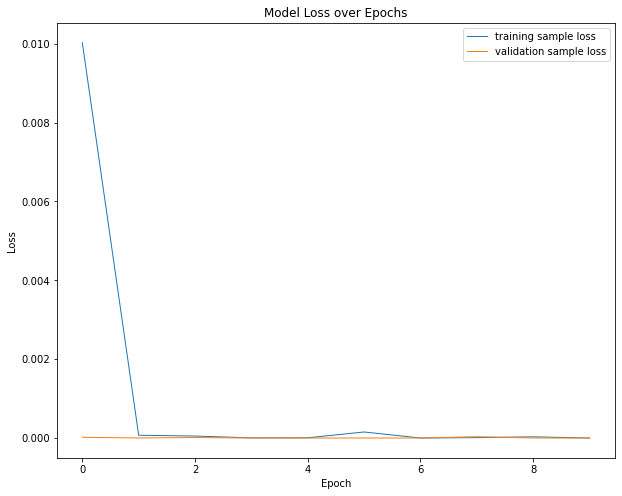

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 7s 47us/sample - loss: 0.0084 - tp: 79823.0000 - fp: 11.0000 - tn: 79982.0000 - fn: 184.0000 - accuracy: 0.9988 - precision: 0.9999 - recall: 0.9977 - auc: 1.0000 - val_loss: 1.0948e-04 - val_tp: 19990.0000 - val_fp: 0.0000e+00 - val_tn: 20007.0000 - val_fn: 3.0000 - val_accuracy: 0.9999 - val_precision: 1.0000 - val_recall: 0.9998 - val_auc: 1.0000
Epoch 2/10
160000/160000 [==============================] - 6s 35us/sample - loss: 1.3661e-04 - tp: 80002.0000 - fp: 2.0000 - tn: 79991.0000 - fn: 5.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9999 - auc: 1.0000 - val_loss: 2.0147e-05 - val_tp: 19993.0000 - val_fp: 0.0000e+00 - val_tn: 20007.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/10
160000/160000 [==============================] - 6s 35us/sample - loss: 6.2707e-06 - tp: 80007.0000 - fp: 0.0

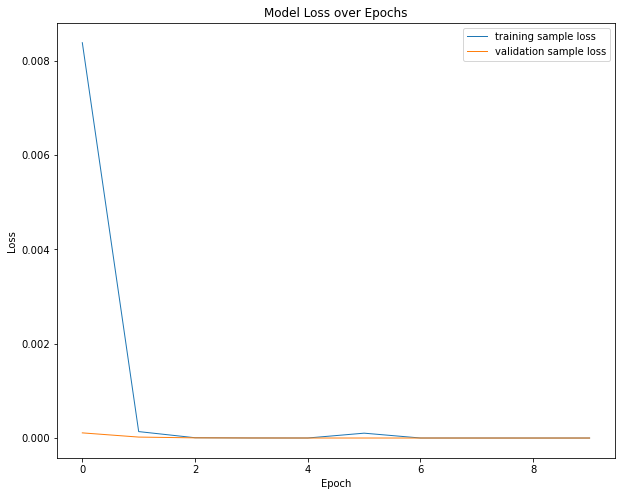

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 7s 46us/sample - loss: 0.0080 - tp: 79985.0000 - fp: 88.0000 - tn: 79905.0000 - fn: 22.0000 - accuracy: 0.9993 - precision: 0.9989 - recall: 0.9997 - auc: 1.0000 - val_loss: 8.0981e-05 - val_tp: 19991.0000 - val_fp: 0.0000e+00 - val_tn: 20007.0000 - val_fn: 2.0000 - val_accuracy: 0.9999 - val_precision: 1.0000 - val_recall: 0.9999 - val_auc: 1.0000
Epoch 2/10
102784/160000 [==================>...........] - ETA: 1s - loss: 8.6611e-05 - tp: 51382.0000 - fp: 0.0000e+00 - tn: 51398.0000 - fn: 4.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9999 - auc: 1.0000

KeyboardInterrupt: 

In [50]:
ypred4c = []
fp_4c, tp_4c,th_4c= [],[],[]
auc_list_4c = []
for i in range(len(mixedsb)): 
    x_train,x_val,y_train,y_val = train_test_split(scaled_dataset[i][:,0:4],scaled_dataset[i][:,-1], test_size = 0.2, random_state=42)
    _,_,sby_train,sby_val = train_test_split(scaled_dataset[i][:,0:4],scaled_dataset[i][:,-2], test_size = 0.2, random_state=42)
    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test)
    ypred4c.append(y_pred)
    fpr, tpr, thresholds = roc_curve(sby_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list_4c.append(auc_value)
    fp_4c.append(fpr)
    tp_4c.append(tpr)
    th_4c.append(thresholds)
    